In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import torch
from dataset_utils.woodscape import WoodScapeDataModule
from dataset_utils import WoodScapeSoilingDataModule
from deeplab_v3p import DeepLabV3PlusModule

In [2]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples, deeplabv3p_apply_dropout
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z

Global steps for using the package:

    1. Load you Dataloader Pytorch-Lightning Module
    2. Load your trained DNN PyTorch-Lightning Module
    3. Add Hook to DNN Module for MC samples extraction
    4. Get Monte-Carlo (MC) samples for In-Distribution (InD) samples dataloader, and Out-of-Distribution (OoD) samples dataloader
    5. Get Entropy from InD and OoD MC samples
    6. Build OoD Detection dataset (with InD and OoD samples)
    7. Build OoD data-driven Detector (classifier)
    8. Show OoD performance results

In this notebook we will cover steps 1 to 5. Remember that training a model on the InD data is a previous step. The rest of the steps will be covered in the next notebook.

# Load datasets

## Load Datamodules

The data should already be downloaded on the system.

In [3]:
ws_dataset_path = './Woodscapes_dataset/'
batch_size = 1

cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }

# same values as in VainF Repository! - Probably not the best Values for Woodscapes!
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

In [4]:
# InD high resolution
ws_dm_normal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


In [5]:
# InD lower resolution
ws_dm_normal_dlv3p_256_512 = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(256, 512),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p_256_512.setup()

DATASET Shuffle Random SEED:  9290


In [6]:
# OoD Anomalies high resolution
ws_dm_anomal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_anomal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


## Instantiate dataloaders

In [7]:
# InD High res
ws_dlv3p_train_loader = ws_dm_normal_dlv3p.train_dataloader()
ws_dlv3p_valid_loader = ws_dm_normal_dlv3p.val_dataloader()
ws_dlv3p_test_loader = ws_dm_normal_dlv3p.test_dataloader()
# OoD anomalies
ws_dlv3p_anomaly_valid_loader = ws_dm_anomal_dlv3p.anomaly_val_dataloader()
ws_dlv3p_anomaly_test_loader = ws_dm_anomal_dlv3p.anomaly_test_dataloader()
# InD lower res
ws_256512_dlv3p_valid_loader = ws_dm_normal_dlv3p_256_512.val_dataloader()
ws_256512_dlv3p_test_loader = ws_dm_normal_dlv3p_256_512.test_dataloader()

In [8]:
# See dataset sizes
ic(len(ws_dlv3p_train_loader))
ic(len(ws_dlv3p_valid_loader))
ic(len(ws_dlv3p_test_loader))
ic(len(ws_dlv3p_anomaly_valid_loader))
ic(len(ws_dlv3p_anomaly_test_loader))
ic(len(ws_256512_dlv3p_valid_loader))
ic(len(ws_256512_dlv3p_test_loader))

ic| len(ws_dlv3p_train_loader): 5929
ic| len(ws_dlv3p_valid_loader): 1482
ic| len(ws_dlv3p_test_loader): 823
ic| len(ws_dlv3p_anomaly_valid_loader): 1482
ic| len(ws_dlv3p_anomaly_test_loader): 823
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823


823

## Woodscape soiling

In [9]:
# OoD Soiling High resolution
woodscape_soil_483640_dm = WoodScapeSoilingDataModule(dataset_dir="./Woodscapes_dataset/soiling_dataset/",
                                                      img_size=(483, 640),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_483640_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [10]:
# OoD Soiling Low resolution
woodscape_soil_256512_dm = WoodScapeSoilingDataModule(dataset_dir="./Woodscapes_dataset/soiling_dataset/",
                                                      img_size=(256, 512),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_256512_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [11]:
# Instantiate dataloaders
# High res
ws_soiling_483640_valid_loader = woodscape_soil_483640_dm.val_dataloader()
ws_soiling_483640_test_loader = woodscape_soil_483640_dm.test_dataloader()
# Low res
ws_soiling_256512_valid_loader = woodscape_soil_256512_dm.val_dataloader()
ws_soiling_256512_test_loader = woodscape_soil_256512_dm.test_dataloader()

## Visualize datasets samples

Let us visualize some samples from these datasets

### InD

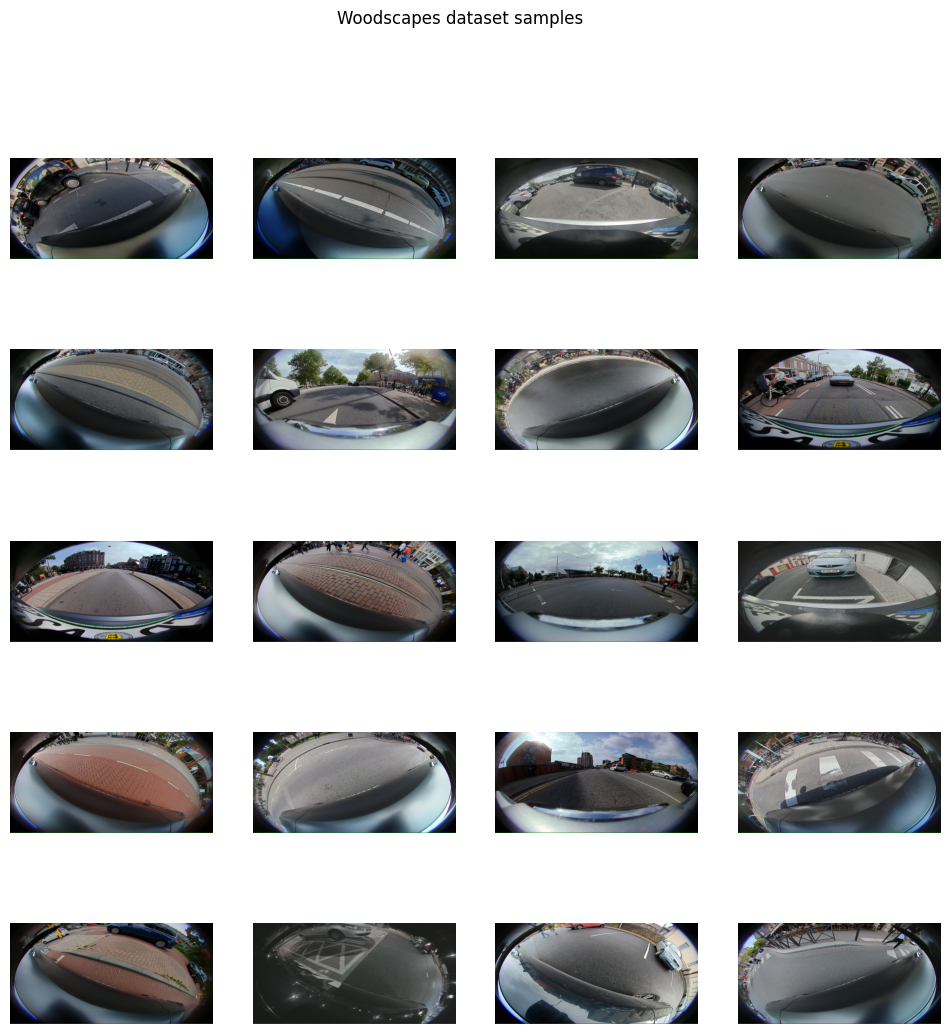

In [12]:
ws_iterator = iter(ws_256512_dlv3p_valid_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = ws_dm_normal_dlv3p_256_512.unprocess_image(next(ws_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes dataset samples")
plt.show()

### OoD anomalies

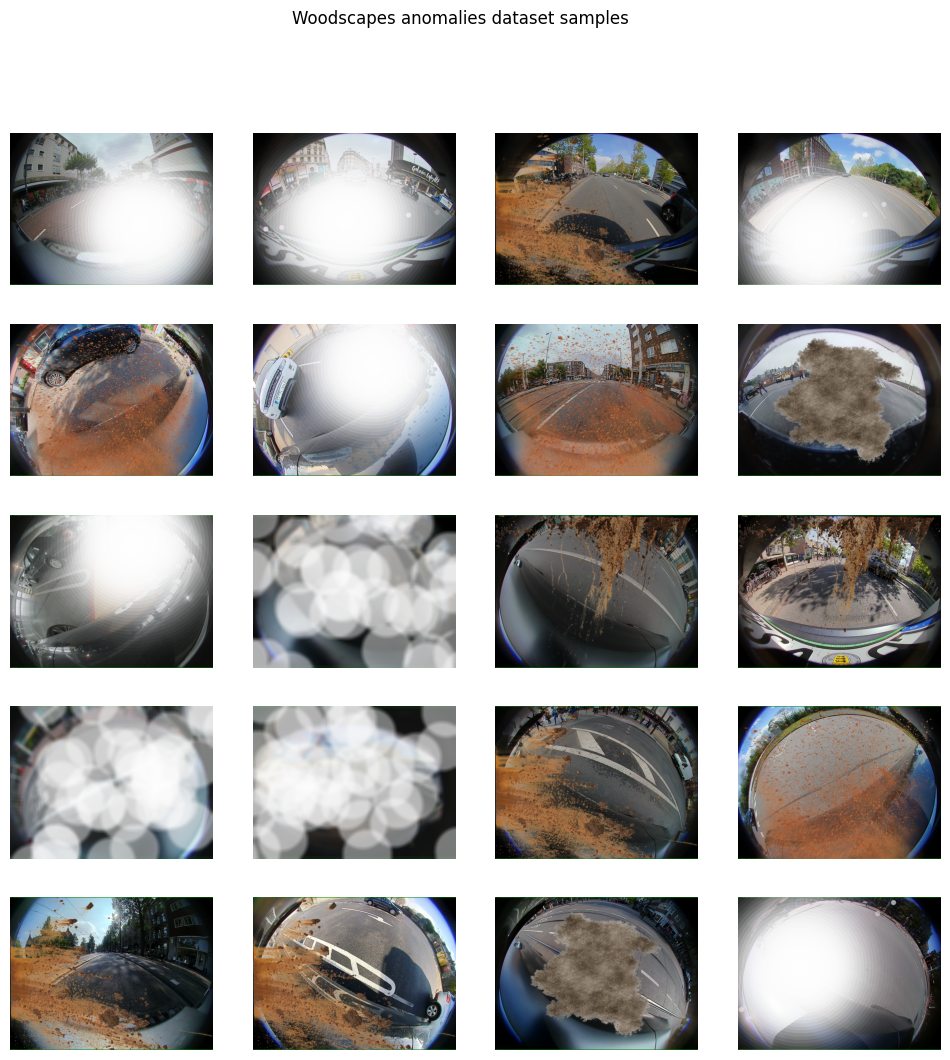

In [13]:
ws_anomaly_iterator = iter(ws_dlv3p_anomaly_test_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = ws_dm_normal_dlv3p_256_512.unprocess_image(next(ws_anomaly_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes anomalies dataset samples")
plt.show()

### OoD soiling

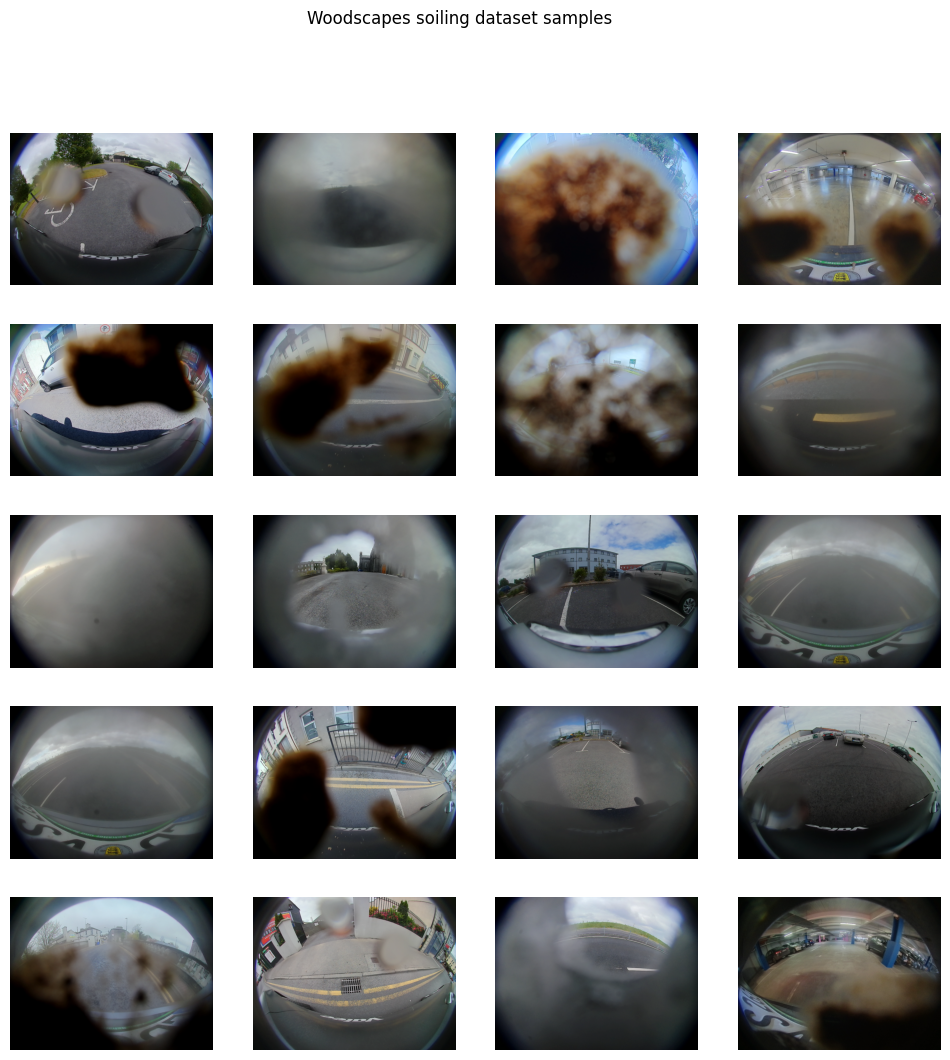

In [14]:
ws_soiling_iterator = iter(ws_soiling_483640_valid_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = woodscape_soil_483640_dm.unprocess_image(next(ws_soiling_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes soiling dataset samples")
plt.show()

So the goal is to build a classifier, starting from the trained model, and needing no OoD samples for training it, only the InD data, to distinguish InD from the OoD images.

# Load Deeplabv3+ Woodscape Trained Model

In [20]:
ws_dlv3p_path = "./checkpoints/last.ckpt"
ws_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=ws_dlv3p_path)

In [21]:
ic(ws_dlv3p_model.pred_loss_type);
ic(ws_dlv3p_model.n_class);

ic| ws_dlv3p_model.pred_loss_type: 'focal_loss'
ic| ws_dlv3p_model.n_class: 10


## Add Hook Deeplabv3+ Woodscape

In [22]:
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.2
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


In [23]:
ws_dlv3p_hook_dropblock2d_layer = Hook(ws_dlv3p_model.deeplab_v3plus_model.drop_block1)

# Get Monte Carlo Samples

This will take some time, be sure to run on GPU

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
mc_samples = 16

In [27]:
ws_dlv3p_model.deeplab_v3plus_model.to(device)
ws_dlv3p_model.deeplab_v3plus_model.eval()
ws_dlv3p_model.deeplab_v3plus_model.apply(deeplabv3p_apply_dropout)  # enable Dropblock

In [28]:
# Check that Dropblock is enabled
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob)
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training)

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.2
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


In [ ]:
ws_dlv3p_ws_normal_train_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                    ws_dlv3p_train_loader,
                                                                    mc_samples,
                                                                    ws_dlv3p_hook_dropblock2d_layer)

ws_dlv3p_ws_normal_valid_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                    ws_dlv3p_valid_loader,
                                                                    mc_samples,
                                                                    ws_dlv3p_hook_dropblock2d_layer)

ws_dlv3p_ws_normal_test_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                   ws_dlv3p_test_loader,
                                                                   mc_samples,
                                                                   ws_dlv3p_hook_dropblock2d_layer)

In [ ]:
ws_dlv3p_ws_anomal_valid_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                    ws_dlv3p_anomaly_valid_loader,
                                                                    mc_samples,
                                                                    ws_dlv3p_hook_dropblock2d_layer)

ws_dlv3p_ws_anomal_test_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                   ws_dlv3p_anomaly_test_loader,
                                                                   mc_samples,
                                                                   ws_dlv3p_hook_dropblock2d_layer)

In [ ]:
ws_dlv3p_ws_soiling_483640_valid_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                            ws_soiling_483640_valid_loader,
                                                                            mc_samples,
                                                                            ws_dlv3p_hook_dropblock2d_layer)

ws_dlv3p_ws_soiling_483640_test_mc_samples = deeplabv3p_get_ls_mcd_samples(ws_dlv3p_model,
                                                                           ws_soiling_483640_test_loader,
                                                                           mc_samples,
                                                                           ws_dlv3p_hook_dropblock2d_layer)

Optionally save MCD predictions

In [ ]:
torch.save(ws_dlv3p_ws_normal_train_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_train_mc_samples.pt')
torch.save(ws_dlv3p_ws_normal_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_normal_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_test_mc_samples.pt')

In [ ]:
torch.save(ws_dlv3p_ws_anomal_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_anomal_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_anomal_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_anomal_test_mc_samples.pt')

In [ ]:
torch.save(ws_dlv3p_ws_soiling_483640_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_soiling_483640_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_soiling_483640_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_soiling_483640_test_mc_samples.pt')

In [ ]:
ws_dlv3p_ws_normal_train_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_train_mc_samples.pt')
ws_dlv3p_ws_normal_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_valid_mc_samples.pt')
ws_dlv3p_ws_normal_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_test_mc_samples.pt')

ws_dlv3p_ws_anomal_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_anomal_valid_mc_samples.pt')
ws_dlv3p_ws_anomal_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_anomal_test_mc_samples.pt')

ws_dlv3p_ws_soiling_483640_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_soiling_483640_valid_mc_samples.pt')
ws_dlv3p_ws_soiling_483640_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_soiling_483640_test_mc_samples.pt')

# Get entropy

In [ ]:
_, ws_dlv3p_h_z_ws_normal_train_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_train_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_normal_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_normal_test_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_test_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_anomal_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_anomal_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_anomal_test_samples_np = get_dl_h_z(ws_dlv3p_ws_anomal_test_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_soiling_483640_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_soil_483640_test_samples_np = get_dl_h_z(ws_dlv3p_ws_soiling_483640_test_mc_samples, mcd_samples_nro=mc_samples)

In [ ]:
np.save('./entropy/woodscapes_h_z_train',
        ws_dlv3p_h_z_ws_normal_train_samples_np)

np.save('./entropy/woodscapes_h_z_valid',
        ws_dlv3p_h_z_ws_normal_valid_samples_np)

np.save('./entropy/woodscapes_h_z_test',
        ws_dlv3p_h_z_ws_normal_test_samples_np)

np.save('./entropy/woodscapes_anomal_h_z_valid',
        ws_dlv3p_h_z_ws_anomal_valid_samples_np)

np.save('./entropy/woodscapes_anomal_h_z_test',
        ws_dlv3p_h_z_ws_anomal_test_samples_np)

np.save('./entropy/woodscapes_soil_h_z_valid',
        ws_dlv3p_h_z_ws_soil_483640_valid_samples_np)

np.save('./entropy/woodscapes_soil_h_z_test',
        ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Save the entropy samples for later use.

Further analysis is performed on the next notebook: [Notebook 2: Evaluate LaREx](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/2_example_deeplab_segmentation_analysis.ipynb?ref_type=heads)